In [22]:
import pandas as pd
import numpy as np
import h5py
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Load Dataset

In [23]:
train = pd.read_csv('train-metadata.csv')
train.head()

/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_2060/876400380.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


# Clean Data

**Focus mainly on how to deal with NaN values in the dataset**

In [24]:
# Show all NaN columns
nan_cols = train.columns[train.isna().any()].tolist()
nan_cols

['age_approx',
 'sex',
 'anatom_site_general',
 'lesion_id',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'mel_mitotic_index',
 'mel_thick_mm']

In [25]:
# Check the number of NaN values in each column
for cols in nan_cols:
    print(f"NaN Values in {cols} column: {train[cols].isna().sum()}")
print(f"Size of the dataset: {train.shape}")

NaN Values in age_approx column: 2798
NaN Values in sex column: 11517
NaN Values in anatom_site_general column: 5756
NaN Values in lesion_id column: 379001
NaN Values in iddx_2 column: 399991
NaN Values in iddx_3 column: 399994
NaN Values in iddx_4 column: 400508
NaN Values in iddx_5 column: 401058
NaN Values in mel_mitotic_index column: 401006
NaN Values in mel_thick_mm column: 400996
Size of the dataset: (401059, 55)


*The columns having a lot of NaN values, relative to the size of the dataset, will get dropped. The rest will get imputed based on appropriate strategies*

In [26]:
train = train.drop(columns=['lesion_id',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'mel_mitotic_index',
 'mel_thick_mm'])

In [27]:
# Imputing missing values
# Calculate the proportion of male and female entries
male_proportion = train['sex'].value_counts(normalize=True)['male']
female_proportion = train['sex'].value_counts(normalize=True)['female']

# Function to impute missing values in 'sex' column based on the calculated proportions
def impute_sex(series):
    return series.apply(lambda x: np.random.choice(['male', 'female'], p=[male_proportion, female_proportion]) if pd.isna(x) else x)

# Apply the custom imputation function to the 'sex' column
train['sex'] = impute_sex(train['sex'])

# Initialize SimpleImputer for 'age_approx' column
mean_age_male = train[train['sex'] == 'male']['age_approx'].mean()
mean_age_female = train[train['sex'] == 'female']['age_approx'].mean()

# Fill NaN values in age_approx based on sex
train.loc[(train['sex'] == 'male') & (train['age_approx'].isna()), 'age_approx'] = mean_age_male
train.loc[(train['sex'] == 'female') & (train['age_approx'].isna()), 'age_approx'] = mean_age_female

In [28]:
# Check the number of NaN values in each column
nan_count_age = train['age_approx'].isna().sum()
nan_count_sex = train['sex'].isna().sum()

print("Number of NaN values in 'age_approx':", nan_count_age)
print("Number of NaN values in 'sex':", nan_count_sex)

Number of NaN values in 'age_approx': 0
Number of NaN values in 'sex': 0


In [29]:
train.dtypes

isic_id                          object
target                            int64
patient_id                       object
age_approx                      float64
sex                              object
anatom_site_general              object
clin_size_long_diam_mm          float64
image_type                       object
tbp_tile_type                    object
tbp_lv_A                        float64
tbp_lv_Aext                     float64
tbp_lv_B                        float64
tbp_lv_Bext                     float64
tbp_lv_C                        float64
tbp_lv_Cext                     float64
tbp_lv_H                        float64
tbp_lv_Hext                     float64
tbp_lv_L                        float64
tbp_lv_Lext                     float64
tbp_lv_areaMM2                  float64
tbp_lv_area_perim_ratio         float64
tbp_lv_color_std_mean           float64
tbp_lv_deltaA                   float64
tbp_lv_deltaB                   float64
tbp_lv_deltaL                   float64


## Process Numeric Features

In [30]:
train_numeric = train.select_dtypes(include=[np.number])
train_numeric = train_numeric.drop(columns=['target', 'tbp_lv_dnn_lesion_confidence', 'tbp_lv_nevi_confidence'])
train_numeric.head()

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,...,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,...,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,60.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,...,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,65.0,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,...,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,55.0,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,...,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


In [31]:
# Select the numeric columns
numeric_cols = train_numeric.columns

# Scale the numeric columns
scaler = StandardScaler()
train_numeric_scaled = scaler.fit_transform(train_numeric)

# Create a new DataFrame with the scaled numeric columns
train_numeric_scaled = pd.DataFrame(train_numeric_scaled, columns=numeric_cols)

### Check for multicollinearity among the feature variables

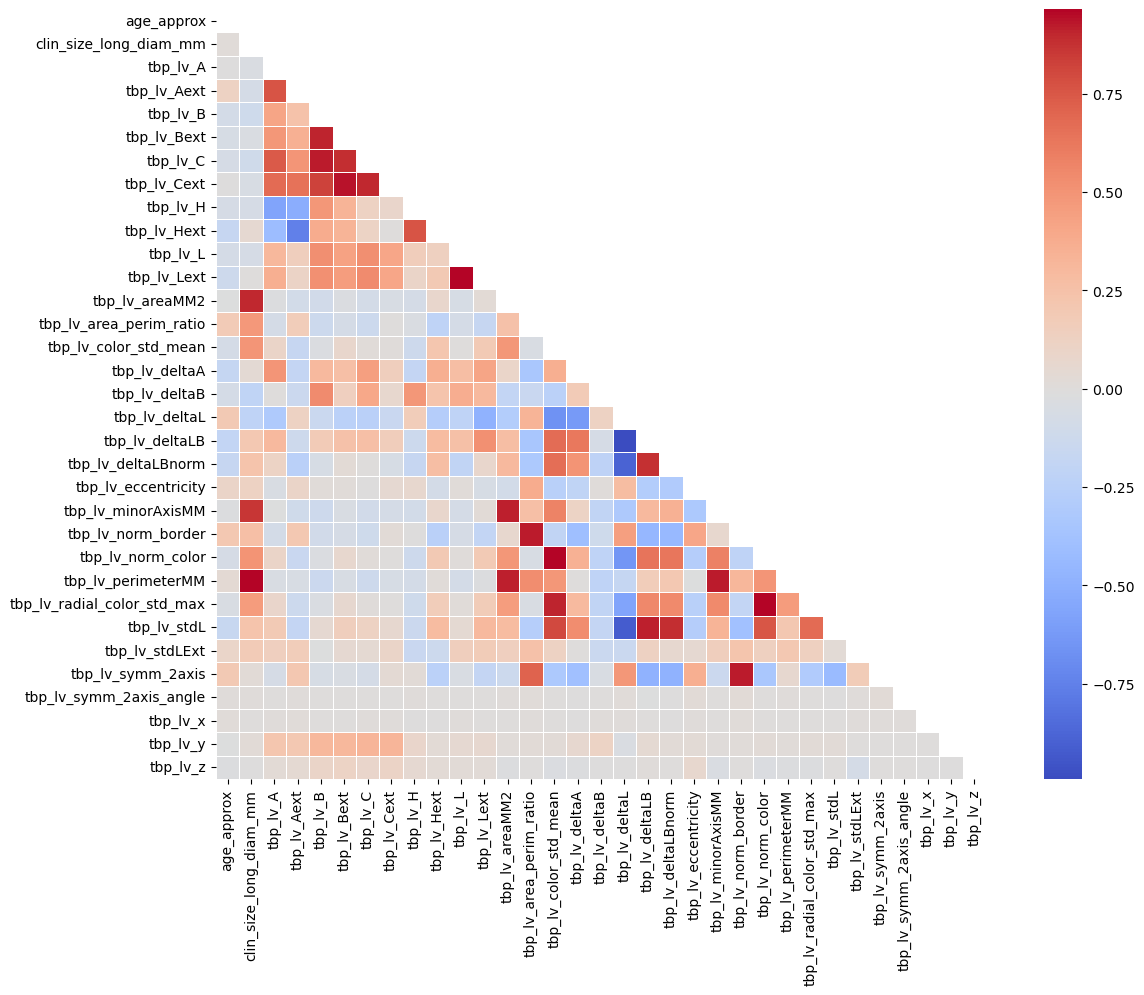

In [32]:
# Compute the correlation matrix
corr = train_numeric_scaled.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap='coolwarm', 
            xticklabels=corr.columns, yticklabels=corr.columns, 
            square=True, linewidths=.5)

plt.show()

*As we can see, there are a lot of features that are correlated with each other. Below, we discuss methods to deal with it.*

## Discussion of Correlated Features

- `tbp_lv_areaMM2` and `tbp_lv_perimeterMM` are the two most correlated features with the target variable. However, as shown by the correlation matrix, they are also highly correlated with each other. Therefore, it would make sense to use a combined feature, such as area//perimeter, something which is available in the dataset (`tbp_lv_area_perim_ratio`). We can then drop area and perimeter features.

- next we have `clin_size_long_diam_mm` and `tbp_lv_minorAxisMM`. these are also highly correlated amongst each other. again, we can create a new combined feature called `lv_size_ratio` == `clin_size_long_diam_mm`//`tbp_lv_minorAxisMM`.

- Next, we look at `tbp_lv_H` and `tbp_lv_Hext` which contains information about the hue inside and outside of the lesion. These are also correlated, as shown by the matrix. We can then define a new feature called `hue_contrast` == |`tbp_lv_H` - `tbp_lv_Hext`|.

- We carry on the same analog for `tbp_lv_L` and `tbp_lv_Lext`, which contains information about the luminance. However, there is already a column `tbp_lv_deltaL` which we can use. Same for `tbp_lv_A`, `tbp_lv_B`, and `tbp_lv_C`. We only the delta features and drop the rest.

- It makes more sense to use `tbp_lv_deltaLBnorm` over `tbp_lv_deltaLB` since it is a normalized version of the same information. 

- `tbp_lv_x`, `tbp_lv_y`, `tbp_lv_z` are just position coordinates. The correlation values also suggest they have a minimal impact on the target variable. 

- `tbp_lv_radial_color_std_max` is a measure of color asymmetry and `tbp_lv_color_std_mean` is a measure of color irregularity. The dataset also contains `tbp_lv_norm_color` which is a normalized average of the two features. Therefore, we can drop the two features (which are also highly correlated with `tbp_lv_norm_color`).

- A similar argument can be made for `tbp_lv_norm_border` which is the normalized average of border asymmetry (`tbp_lv_symm_2axis`) and border jagedness (`tbp_lv_area_perim_ratio`). This makes us revisit keeping the area-perimeter feature, as mentioned in the first point. 

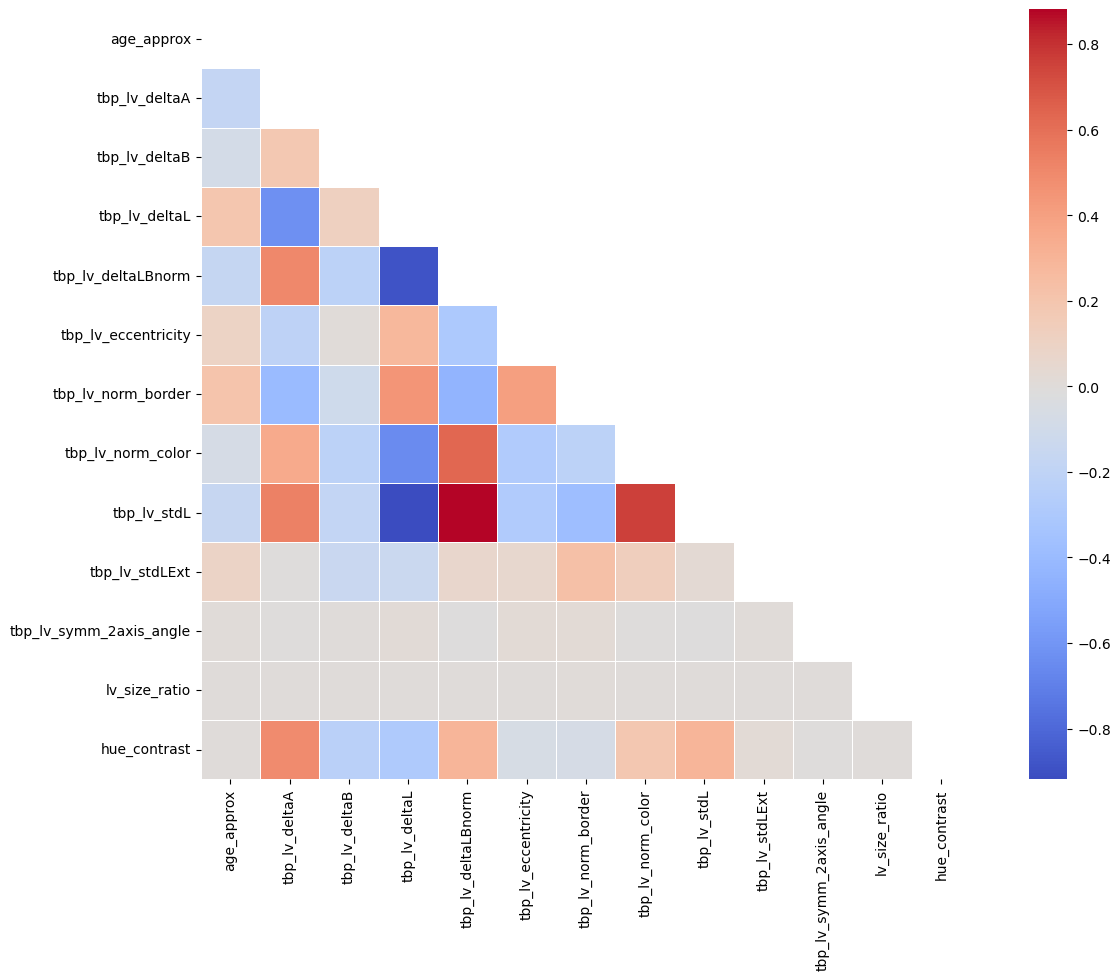

In [33]:
#Add new features
train_numeric_scaled['lv_size_ratio'] = train_numeric_scaled['clin_size_long_diam_mm']/train_numeric_scaled['tbp_lv_minorAxisMM']
train_numeric_scaled['hue_contrast'] = np.abs(train_numeric_scaled['tbp_lv_H'] - train_numeric_scaled['tbp_lv_Hext'])

features_to_drop = ['tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
                    'tbp_lv_Lext', 'tbp_lv_L', 'tbp_lv_deltaLB', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
                    'tbp_lv_radial_color_std_max', 'tbp_lv_color_std_mean', 'tbp_lv_symm_2axis', 'tbp_lv_area_perim_ratio',
                    'tbp_lv_areaMM2', 'tbp_lv_perimeterMM', 'clin_size_long_diam_mm', 'tbp_lv_minorAxisMM', 
                    'tbp_lv_H', 'tbp_lv_Hext']

train_numeric_scaled = train_numeric_scaled.drop(columns=features_to_drop)

# Compute the correlation matrix
corr = train_numeric_scaled.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", cmap='coolwarm', 
            xticklabels=corr.columns, yticklabels=corr.columns, 
            square=True, linewidths=.5)

plt.show()

## Correlation of New Features with Target Variable

*Since the target variable is binary, it does not make sense to use the standard pearson correlation coefficient. Instead, we use a function from SciPy that calculates the Point-Biserial correlation. The point-biserial correlation is a special case of the Pearson correlation that measures the relationship between a binary variable and a continuous variable.*

In [34]:
# Calculate the point biserial correlation for each numeric column
correlation_results_new = {}

# Loop through each numeric column and calculate the point biserial correlation
for column in train_numeric_scaled.columns:
    correlation, p_value = pointbiserialr(train_numeric_scaled[column], train['target']) 
    correlation_results_new[column] = {'correlation': correlation, 'p-value': p_value}

# Convert results to a DataFrame for better visualization
correlation_df_new = pd.DataFrame(correlation_results_new).T

# Display the correlation results
correlation_df_new

,correlation,p-value
age_approx,0.007706,1.059553e-06
tbp_lv_deltaA,-0.001046,5.078609e-01
tbp_lv_deltaB,-0.035069,2.423273e-109
tbp_lv_deltaL,-0.011256,1.012716e-12
tbp_lv_deltaLBnorm,0.015172,7.334365e-22
tbp_lv_eccentricity,-0.005295,7.977759e-04
tbp_lv_norm_border,0.006747,1.928475e-05
tbp_lv_norm_color,0.022264,3.718097e-45
tbp_lv_stdL,0.012669,1.028100e-15
tbp_lv_stdLExt,0.026084,2.559066e-61


## Processing Categorical Features

In [35]:
train_categorical = train.select_dtypes(include=[object])
train_categorical = train_categorical.drop(columns=['isic_id', 'patient_id', 'tbp_lv_location','attribution', 
                                                    'copyright_license', 'iddx_full', 'iddx_1'])
train_categorical.head()

,sex,anatom_site_general,image_type,tbp_tile_type,tbp_lv_location_simple
0,male,lower extremity,TBP tile: close-up,3D: white,Right Leg
1,male,head/neck,TBP tile: close-up,3D: white,Head & Neck
2,male,posterior torso,TBP tile: close-up,3D: XP,Torso Back
3,male,anterior torso,TBP tile: close-up,3D: XP,Torso Front
4,male,anterior torso,TBP tile: close-up,3D: white,Torso Front


In [36]:
nan_cols = train_categorical.columns[train_categorical.isna().any()].tolist()
nan_cols

['anatom_site_general']

*Information included the anatom_site_general is also provided in tbp_lv_location_simple, without any missing values. we can drop the anatom feature.*

In [37]:
train_categorical = train_categorical.drop(columns=['anatom_site_general'])
train_categorical.head()

,sex,image_type,tbp_tile_type,tbp_lv_location_simple
0,male,TBP tile: close-up,3D: white,Right Leg
1,male,TBP tile: close-up,3D: white,Head & Neck
2,male,TBP tile: close-up,3D: XP,Torso Back
3,male,TBP tile: close-up,3D: XP,Torso Front
4,male,TBP tile: close-up,3D: white,Torso Front


In [38]:
train_categorical = train_categorical.drop(columns=['image_type'])  
train_categorical.head()

,sex,tbp_tile_type,tbp_lv_location_simple
0,male,3D: white,Right Leg
1,male,3D: white,Head & Neck
2,male,3D: XP,Torso Back
3,male,3D: XP,Torso Front
4,male,3D: white,Torso Front


In [39]:
train_categorical = train_categorical.astype('category')
train_categorical.dtypes

sex                       category
tbp_tile_type             category
tbp_lv_location_simple    category
dtype: object

In [40]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
train_categorical_encoded = encoder.fit_transform(train_categorical)

train_categorical_encoded = pd.DataFrame(train_categorical_encoded, columns=encoder.get_feature_names_out(train_categorical.columns))

full_dataset = pd.concat([train_numeric_scaled, train_categorical_encoded], axis=1)
full_dataset['target'] = train['target']
full_dataset['isic_id'] = train['isic_id']
full_dataset.head()

full_dataset.to_csv('full_dataset.csv', index=False)